# Time Series Forecasting in machine learning: Tesla stock prediction using LSTM Regression

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_predict
import pmdarima
from sklearn.metrics import mean_absolute_error 
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

import numpy as np
from numpy import *
import pandas as pd
from pandas import MultiIndex, Int16Dtype
import matplotlib.pyplot as plt

import os
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
from textwrap import wrap
import inspect
import itertools

import inspect
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xlsxwriter
import xlwings as xw
from copy import copy
import scipy.stats as ss
import math
from statsmodels.stats.stattools import durbin_watson
from scipy.optimize import curve_fit
import time
from IPython import display as ICD
import warnings
from openpyxl.styles import Alignment
from openpyxl.styles import PatternFill 
import re

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import callbacks
from keras.layers import Dropout
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scikeras
from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasClassifier

In [3]:
tf.__version__

'2.9.0'

In [4]:
directory='C:\\Users\\lairx78\\Desktop\\python'
os.chdir(directory)

In [5]:
# Read the dataframe
data=pd.read_csv('TSLA.csv')
data_lstm=array(data['Open']).reshape(-1, 1).astype('float32')

# Data processing

Normalize the dataset

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_lstm_transform = scaler.fit_transform(data_lstm)

Train Test Split

In [7]:
training_size = int(len(data_lstm_transform)*0.75)
train_data_lstm_transform = data_lstm_transform[:training_size]
test_data_lstm_transform = data_lstm_transform[training_size:]

Define timesteps

In [8]:
timesteps=100

train = TimeseriesGenerator(train_data_lstm_transform, train_data_lstm_transform, length = timesteps, batch_size=len(train_data_lstm_transform))
test = TimeseriesGenerator(test_data_lstm_transform, test_data_lstm_transform, length = timesteps, batch_size=len(test_data_lstm_transform))
x_train, y_train= train[0]
x_test, y_test= test[0]

In [9]:
print('The shape of train dataset: \n', 'x: ', x_train.shape, ' y: ', y_train.shape, '\n')
print('The shape of test dataset: \n', 'x: ', x_test.shape, ' y: ', y_test.shape)

The shape of train dataset: 
 x:  (842, 100, 1)  y:  (842, 1) 

The shape of test dataset: 
 x:  (215, 100, 1)  y:  (215, 1)


# Grid search method: find the best hyperparameters for lstm model

In [10]:
warnings.filterwarnings('ignore')

start = time.time()

def create_model(neurons):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.1))
    model.add(LSTM(neurons, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(neurons))
    model.add(Dropout(0.1))
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse')
    return model
    
neurons = [32,64]
batch_size = [32,64]
epochs = [100]

hypara_dict = dict(model__neurons=neurons, batch_size=batch_size, epochs=epochs)
    
keras_model = KerasRegressor(model=create_model, verbose=2)
grid_model = GridSearchCV(estimator=keras_model, param_grid=hypara_dict, n_jobs=1, cv=3)
grid_model.fit(x_train, y_train, validation_data = (x_test, y_test))

warnings.filterwarnings('default')

print('Grid search time used: ' + str(round(time.time() - start, 2)) + ' seconds')

Epoch 1/100
18/18 - 13s - loss: 0.0984 - val_loss: 0.0072 - 13s/epoch - 717ms/step
Epoch 2/100
18/18 - 1s - loss: 0.0150 - val_loss: 0.0132 - 610ms/epoch - 34ms/step
Epoch 3/100
18/18 - 0s - loss: 0.0068 - val_loss: 0.0065 - 396ms/epoch - 22ms/step
Epoch 4/100
18/18 - 0s - loss: 0.0053 - val_loss: 0.0051 - 320ms/epoch - 18ms/step
Epoch 5/100
18/18 - 0s - loss: 0.0052 - val_loss: 0.0055 - 283ms/epoch - 16ms/step
Epoch 6/100
18/18 - 0s - loss: 0.0047 - val_loss: 0.0052 - 284ms/epoch - 16ms/step
Epoch 7/100
18/18 - 0s - loss: 0.0043 - val_loss: 0.0049 - 304ms/epoch - 17ms/step
Epoch 8/100
18/18 - 0s - loss: 0.0049 - val_loss: 0.0047 - 282ms/epoch - 16ms/step
Epoch 9/100
18/18 - 0s - loss: 0.0060 - val_loss: 0.0042 - 277ms/epoch - 15ms/step
Epoch 10/100
18/18 - 0s - loss: 0.0052 - val_loss: 0.0040 - 281ms/epoch - 16ms/step
Epoch 11/100
18/18 - 0s - loss: 0.0040 - val_loss: 0.0038 - 290ms/epoch - 16ms/step
Epoch 12/100
18/18 - 0s - loss: 0.0042 - val_loss: 0.0037 - 287ms/epoch - 16ms/step
E

In [11]:
print(grid_model.best_params_)

{'batch_size': 64, 'epochs': 100, 'model__neurons': 64}


# Train lstm model using the optimal hyperparameters

Using callbacks techniques:
    
callbacks.EarlyStopping: Stop training when a monitored metric has stopped improving in 10 Epoch 
<br>
callbacks.ModelCheckpoint: Save a model and weights in a checkpoint file at some interval

In [21]:
start = time.time()

def seed_tensorflow(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.compat.v1.set_random_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = str(seed)

seed_tensorflow(seed=1234)


best_parameter_lstm_model=create_model(grid_model.best_params_['model__neurons'])
earlystopping=callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=False)


filepath='bestcheckpoint_TSLA.hdf5'
checkpoint=callbacks.ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)


best_parameter_lstm_model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = grid_model.best_params_['batch_size'], 
                              epochs = grid_model.best_params_['epochs'], verbose = 2, callbacks=[earlystopping, checkpoint])
best_parameter_lstm_model.load_weights(filepath)

print('Lstm model training, time used: ' + str(round(time.time() - start, 2)) + ' seconds')

Epoch 1/100
14/14 - 4s - loss: 0.0475 - val_loss: 0.0179 - 4s/epoch - 298ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0073 - val_loss: 0.0055 - 274ms/epoch - 20ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0041 - val_loss: 0.0053 - 273ms/epoch - 20ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0032 - val_loss: 0.0053 - 271ms/epoch - 19ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0030 - val_loss: 0.0048 - 279ms/epoch - 20ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0033 - val_loss: 0.0042 - 296ms/epoch - 21ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0032 - val_loss: 0.0044 - 248ms/epoch - 18ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0034 - val_loss: 0.0039 - 276ms/epoch - 20ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0028 - val_loss: 0.0039 - 282ms/epoch - 20ms/step
Epoch 10/100
14/14 - 0s - loss: 0.0026 - val_loss: 0.0041 - 262ms/epoch - 19ms/step
Epoch 11/100
14/14 - 0s - loss: 0.0024 - val_loss: 0.0036 - 283ms/epoch - 20ms/step
Epoch 12/100
14/14 - 0s - loss: 0.0025 - val_loss: 0.0034 - 275ms/epoch - 20ms/step
Epo

In [23]:
x_train_predict=scaler.inverse_transform(best_parameter_lstm_model.predict(x_train))

27/27 [==============================] - 1s 25ms/step


In [24]:
x_test_predict=scaler.inverse_transform(best_parameter_lstm_model.predict(x_test))

7/7 [==============================] - 0s 23ms/step


# Data visualization

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

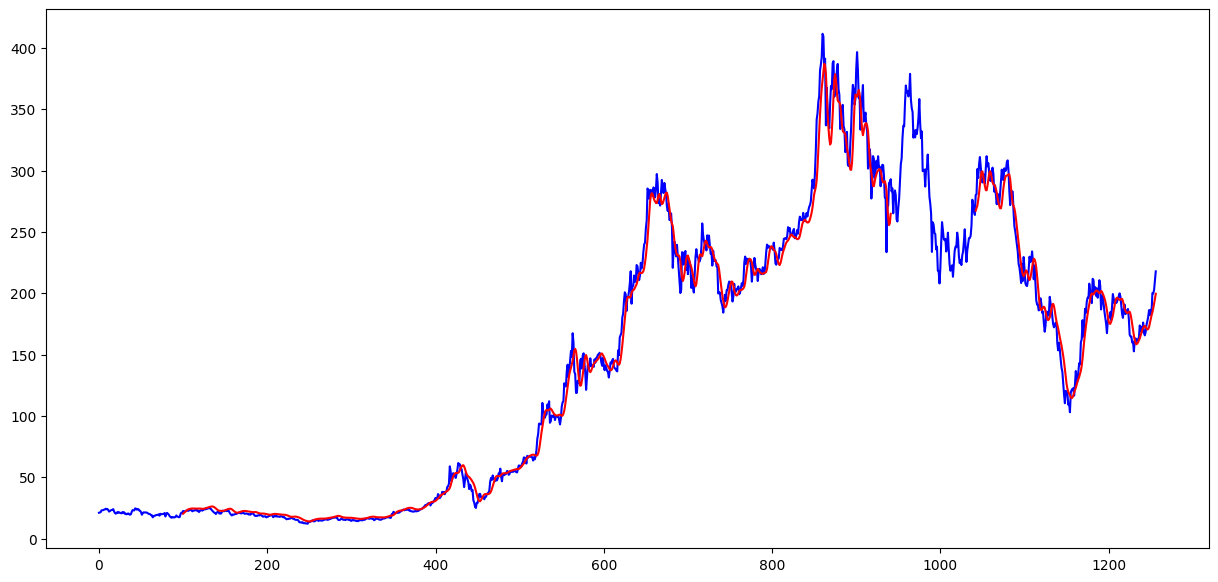

In [25]:
fig = plt.figure(figsize = (15, 7))
ax= fig.add_subplot()

plot_x_train_predict=[np.nan]*timesteps+list(x_train_predict.reshape(1,-1)[0])
plot_x_test_predict=[np.nan]*timesteps+list(x_test_predict.reshape(1,-1)[0])

plot_predict=plot_x_train_predict+plot_x_test_predict

plt.plot(list(range(0, len(data))), list(data['Open']), label=('actual'), color = 'blue')
plt.plot(list(range(0, len(data))), plot_predict, label=('prediction'), color = 'red')
plt.plot